<a href="https://colab.research.google.com/github/aroonalok/deep-learning-foundations/blob/main/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [2]:
import logging
import torch
from torch.utils import data
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.random import default_rng
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from early_stopping import EarlyStopping

##Data

In [3]:
class ExpDataset(Dataset):
  def __init__(self, data):
    # shape = (#num, 2, 1)
    shape = (-1,2,1)
    self.data = data.view(shape)

  def __len__(self):
    return self.data.size(dim=0)

  def __getitem__(self, idx):
    sample = self.data[idx][0], self.data[idx][1]
    return sample

In [4]:
def plot_data(data,title=''):
  df = pd.DataFrame(data=data,columns=['X','y'])
  sns.scatterplot(data=df,x='X',y='y',s=1.5).set(title=f"{title} {data.shape}")

def plot_loss(data):
  df = pd.DataFrame(data=data,columns=['epoch','training','validation'])
  min_validation_loss_epoch = df['validation'].argmin()
  df_melted = df.melt(id_vars=['epoch'], 
                      value_vars=['training', 'validation'],
                      var_name='Loss Type',
                      value_name='loss')
  sns.lineplot(data=df_melted,x='epoch',y='loss',hue='Loss Type')
  plt.axvline(min_validation_loss_epoch, linestyle='--', color='r')

def plot_predictions(data):
  df = pd.DataFrame(data=data,columns=['X','target','predicted'])
  df_melted = df.melt(id_vars=['X'], 
                      value_vars=['target', 'predicted'],
                      var_name='y type',
                      value_name='y')
  sns.scatterplot(data=df_melted,x='X',y='y',hue='y type',s=1.5).set(title="Model Predictions")

Generate example data

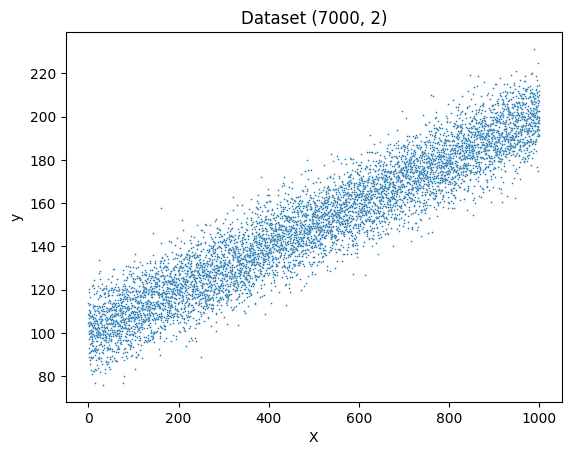

In [5]:
n = 7000
intercept = 100
slope = 0.1
rng = default_rng()
X = np.linspace(start=0,stop=1e3,num=n,dtype='float32')
Y = np.add(slope*X, intercept+rng.normal(loc=0, scale=10, size=n), dtype='float32')

data = np.stack((X,Y), 1)
plot_data(data,"Dataset")

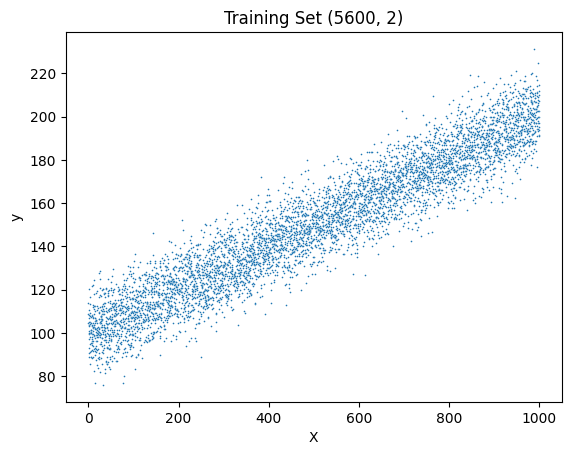

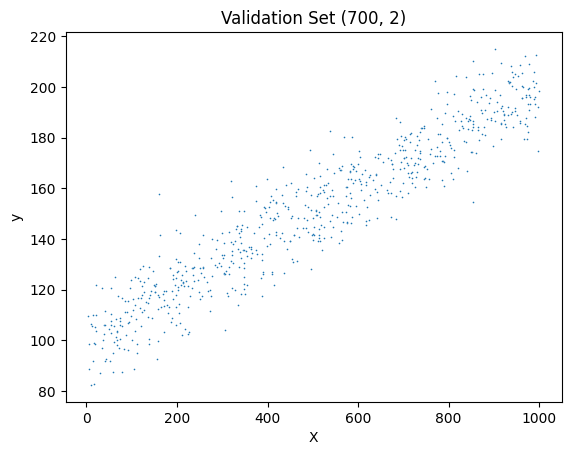

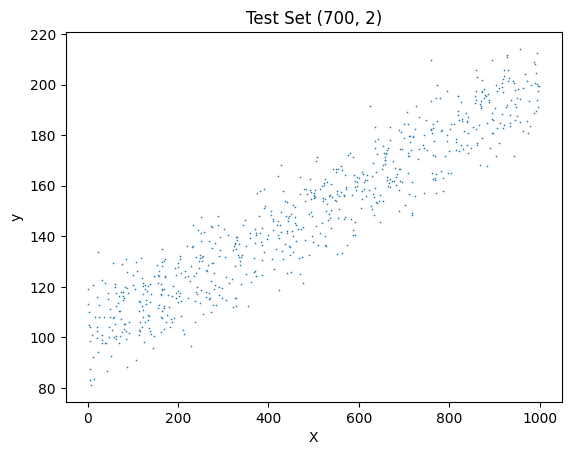

In [6]:
train_data, test_valid_data = train_test_split(data,train_size=0.8)
valid_data, test_data = train_test_split(test_valid_data,train_size=0.5)

for i, (d, t) in enumerate([(train_data,"Training Set"),
                          (valid_data,"Validation Set"),
                          (test_data,"Test Set")]):
  plt.figure(i)
  plot_data(d,t)

In [7]:
batch_size = 512

training_data = ExpDataset(torch.from_numpy(train_data))
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

validation_data = ExpDataset(torch.from_numpy(valid_data))
validation_dataloader = DataLoader(validation_data, batch_size=valid_data.shape[0], shuffle=True)

testing_data = ExpDataset(torch.from_numpy(test_data))
test_dataloader = DataLoader(testing_data, batch_size=test_data.shape[0], shuffle=True)

##Model Definition

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")


Using cpu device


In [9]:
class LinearRegression(nn.Module):
  def __init__(self):
    super(LinearRegression, self).__init__()
    self.linear = nn.Linear(1, 1)

  def forward(self, x):
    return self.linear(x)

  def weight(self):
    return self.linear.weight.item()
  
  def bias(self):
    return self.linear.bias.item()


In [10]:
model = LinearRegression().to(device)
print(model)

LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [11]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Model Training

In [12]:
def train(dataloader, model, loss_fn, optimizer):
  model.train()
  epoch_loss = []
  for (X, y) in dataloader:
    X, y = X.to(device), y.to(device)

    #Forward pass
    pred = model(X)

    # Compute prediction error
    loss = loss_fn(pred, y)
    epoch_loss.append(loss.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  epoch_loss = np.mean(epoch_loss)
  return epoch_loss

def validate(dataloader, model, loss_fn):
  model.eval()
  epoch_loss = []
  for (X, y) in dataloader:
    X, y = X.to(device), y.to(device)
    
    with torch.no_grad():
      #Forward pass
      pred = model(X)
      
      # Compute prediction error
      loss = loss_fn(pred, y)
      epoch_loss.append(loss.item())

  epoch_loss = np.mean(epoch_loss)
  return epoch_loss

def stop_training_callback():
  print("Early stopping training!!!")
  global STOP_TRAINING 
  STOP_TRAINING = True

[Epoch 1/50000] training loss: 352325.3125 | validation loss: 346733.5
[Epoch 5000/50000] training loss: 695.9863447709517 | validation loss: 725.173095703125
[Epoch 10000/50000] training loss: 100.37792067094283 | validation loss: 99.61942291259766
Early stopping training!!!
Training complete at [Epoch 10159/50000] final training loss: 100.52455485950817 | final validation loss: 99.46937561035156


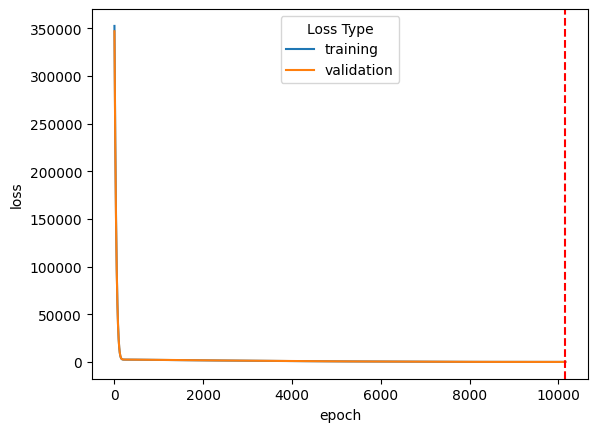

In [13]:
logging.basicConfig(filename='./linear_regression.log',
                    encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', 
                    datefmt='%m/%d/%Y %H:%M:%S',
                    # Resets any previous configuration
                    force=True)

early_stopping = EarlyStopping(patience=100,
                               min_progress_delta=1e-1,
                               path="./model.ckpt")

STOP_TRAINING = False

max_epoch = 50000
print_every_n = 5000

loss_curve = []

epoch = 1
while epoch <= max_epoch and not STOP_TRAINING:
  training_loss = train(train_dataloader, model, loss_fn, optimizer)
  validation_loss = validate(validation_dataloader, model, loss_fn)
  loss_curve.append([epoch,training_loss,validation_loss])
  # Print the first epoch metric and then print_every_n epochs
  if epoch==1 or (epoch)%print_every_n == 0:
    print(f"[Epoch {epoch}/{max_epoch}] training loss: {training_loss} | validation loss: {validation_loss}")
  early_stopping(validation_loss, model, stop_training_callback)
  epoch += 1
print(f"Training complete at [Epoch {epoch-1}/{max_epoch}] final training loss: {training_loss} | final validation loss: {validation_loss}")
loss_curve = np.asarray(loss_curve, dtype=np.float32)
plot_loss(loss_curve)

Trained Parameters

In [14]:
print(f"Slope: {model.weight()}")
print(f"Intercept: {model.bias()}")

Slope: 0.10128064453601837
Intercept: 99.51106262207031


# Model Prediction

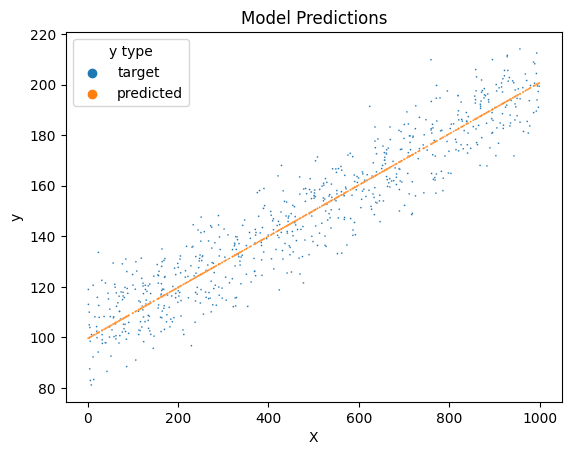

In [15]:
for batch, (X, y) in enumerate(test_dataloader):
  X, y = X.to(device), y.to(device)
  
  #Forward pass
  with torch.no_grad():
    pred = model(X)
    pred = pred.detach()

  #Plot predictions
  data = torch.stack((X,y,pred),dim=1)
  data = torch.squeeze(data)
  plt.figure(batch)
  plot_predictions(data)